In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ==============================================================================
# LANGKAH 1: PENGAMBILAN DATA
# ==============================================================================
# Mengambil data historis Ethereum (ETH-USD) dari Yahoo Finance
# Kita ambil data selama 5 tahun untuk mendapatkan dataset yang cukup besar
ticker = 'ETH-USD'
# data = yf.download(ticker, start='2021-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))
data = yf.download(ticker, start='2021-01-01', end='2025-07-01')

print("Data Awal Dimuat:")
print(data.tail())
print("\n" + "="*50 + "\n")



/tmp/ipython-input-4137197216.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2021-01-01', end='2025-07-01')
[*********************100%***********************]  1 of 1 completed

Data Awal Dimuat:
Price             Close         High          Low         Open       Volume
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD
Date                                                                       
2025-06-26  2416.146729  2519.619873  2399.533936  2419.154785  18300413888
2025-06-27  2423.866943  2463.154785  2386.324951  2416.023193  15309834970
2025-06-28  2437.109375  2448.191650  2407.761719  2423.925293   8273074809
2025-06-29  2500.959961  2523.320557  2417.625244  2437.114746  12500580479
2025-06-30  2486.464355  2521.720459  2438.054932  2500.605469  16859727663




In [5]:
# ==============================================================================
# LANGKAH 2: FEATURE ENGINEERING (MEMBUAT FITUR)
# ==============================================================================
# Membuat fitur baru untuk membantu model belajar pola data
def create_features(df):
    df = df.copy()
    # Fitur berbasis waktu
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year

    # Fitur Lag (harga penutupan beberapa hari sebelumnya)
    # Ini penting agar model tahu harga di masa lalu
    for lag in range(1, 8): # Menggunakan lag 1 sampai 7 hari
        df[f'lag_close_{lag}'] = df['Close'].shift(lag)

    # Fitur Rolling Window (rata-rata bergerak)
    # Ini membantu model mengidentifikasi tren
    df['rolling_mean_7'] = df['Close'].shift(1).rolling(window=7).mean()
    df['rolling_mean_30'] = df['Close'].shift(1).rolling(window=30).mean()

    return df

data_features = create_features(data)

In [6]:
# ==============================================================================
# LANGKAH 3: MEMBUAT VARIABEL TARGET
# ==============================================================================
# Target kita adalah harga penutupan (Close) 7 hari di masa depan
target_days = 15
data_features['target'] = data_features['Close'].shift(-target_days)

# Menghapus baris yang memiliki nilai NaN (muncul karena proses shift dan rolling)
data_cleaned = data_features.dropna()

print("Data Setelah Feature Engineering dan Pembuatan Target:")
print(data_cleaned.tail())
print("\n" + "="*50 + "\n")


Data Setelah Feature Engineering dan Pembuatan Target:
Price             Close         High          Low         Open       Volume  \
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD   
Date                                                                          
2025-06-11  2773.529297  2877.629395  2746.459961  2813.739746  30705408054   
2025-06-12  2651.795166  2784.262695  2619.966553  2773.597900  25924959613   
2025-06-13  2579.486084  2651.915527  2443.962646  2651.915527  37986747138   
2025-06-14  2533.444092  2580.158203  2491.490723  2579.721436  14285000473   
2025-06-15  2546.837158  2558.677734  2493.204590  2533.183350  13961893828   

Price      day_of_week day_of_year month  year  lag_close_1  lag_close_2  \
Ticker                                                                     
Date                                                                       
2025-06-11           2         162     6  2025  2813.517578  2681.517090   
2025-06-

In [7]:
# ==============================================================================
# LANGKAH 4: MEMISAHKAN FITUR (X) DAN TARGET (y)
# ==============================================================================
# Kolom 'target' adalah yang ingin kita prediksi (y)
# Kolom lainnya (kecuali harga asli) adalah fitur untuk prediksi (X)
FEATURES_TO_USE = [
    'day_of_week', 'day_of_year', 'month', 'year',
    'lag_close_1', 'lag_close_2', 'lag_close_3', 'lag_close_4',
    'lag_close_5', 'lag_close_6', 'lag_close_7',
    'rolling_mean_7', 'rolling_mean_30'
]

X = data_cleaned[FEATURES_TO_USE]
y = data_cleaned['target']

In [8]:
# ==============================================================================
# LANGKAH 5: MEMBAGI DATASET (TRAINING & TESTING)
# ==============================================================================
# Untuk data time series, kita tidak boleh mengacak data.
# Kita bagi data secara berurutan: 80% data lama untuk training, 20% data baru untuk testing.
split_percentage = 0.8
split_index = int(len(X) * split_percentage)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Ukuran data training: {len(X_train)} baris")
print(f"Ukuran data testing: {len(X_test)} baris")
print("\n" + "="*50 + "\n")

Ukuran data training: 1277 baris
Ukuran data testing: 320 baris




In [9]:
# ==============================================================================
# LANGKAH 6: MELATIH MODEL XGBOOST
# ==============================================================================
# Membuat model XGBoost Regressor
# Parameter ini bisa di-tuning untuk hasil yang lebih baik (Hyperparameter Tuning)
model = xgb.XGBRegressor(
    n_estimators=1000,      # Jumlah pohon
    learning_rate=0.01,     # Seberapa cepat model belajar
    max_depth=5,            # Kedalaman maksimum pohon
    subsample=0.8,          # Persentase sampel yang digunakan per pohon
    colsample_bytree=0.8,   # Persentase fitur yang digunakan per pohon
    objective='reg:squarederror',
    n_jobs=-1,              # Menggunakan semua core CPU
    random_state=42
)

# Melatih model dengan data training
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:871.85302	validation_1-rmse:629.16937
[1]	validation_0-rmse:864.11032	validation_1-rmse:623.58865
[2]	validation_0-rmse:856.39442	validation_1-rmse:622.01878
[3]	validation_0-rmse:848.86941	validation_1-rmse:616.18204
[4]	validation_0-rmse:841.31929	validation_1-rmse:610.70539
[5]	validation_0-rmse:834.01129	validation_1-rmse:605.15282
[6]	validation_0-rmse:826.53776	validation_1-rmse:599.79067
[7]	validation_0-rmse:819.29133	validation_1-rmse:593.69008
[8]	validation_0-rmse:812.06159	validation_1-rmse:588.46040
[9]	validation_0-rmse:804.91267	validation_1-rmse:583.46953
[10]	validation_0-rmse:797.78051	validation_1-rmse:582.22001
[11]	validation_0-rmse:790.89486	validation_1-rmse:577.41303
[12]	validation_0-rmse:783.90629	validation_1-rmse:575.87160
[13]	validation_0-rmse:776.95563	validation_1-rmse:574.21967
[14]	validation_0-rmse:770.22373	validation_1-rmse:568.63993
[15]	validation_0-rmse:763.68364	validation_1-rmse:564.08765
[16]	validation_0-rmse:756.98103	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [10]:
# ==============================================================================
# LANGKAH 7: EVALUASI MODEL
# ==============================================================================
# Membuat prediksi pada data testing
y_pred = model.predict(X_test)

# Menghitung metrik evaluasi
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Hasil Evaluasi Model pada Data Testing:")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R-squared (R²): {r2:.4f}")
print("\n" + "="*50 + "\n")


Hasil Evaluasi Model pada Data Testing:
Mean Absolute Error (MAE): $348.40
Root Mean Squared Error (RMSE): $435.68
R-squared (R²): 0.4433




In [11]:
# ==============================================================================
# LANGKAH 8: MEMBUAT PREDIKSI UNTUK 7 HARI KE DEPAN
# ==============================================================================
# Untuk memprediksi masa depan, kita butuh data terakhir untuk membuat fitur
# Ambil data 30 hari terakhir (karena rolling window terbesar kita adalah 30)
last_30_days_data = data.iloc[-30:]

# Buat placeholder untuk menyimpan hasil prediksi
future_predictions = []
current_date = last_30_days_data.index[-1]

# Loop untuk 7 hari ke depan
for i in range(1, target_days + 1):
    # Buat fitur untuk hari yang akan diprediksi
    # Kita gunakan data terakhir yang tersedia
    last_known_data_for_feature_creation = data.iloc[-(30+target_days):] # Ambil data yang cukup untuk lag dan rolling

    # Buat fitur seperti saat training
    features_for_prediction = create_features(last_known_data_for_feature_creation)

    # Ambil baris terakhir yang fiturnya lengkap untuk prediksi
    # Baris ini merepresentasikan data 'hari ini' untuk memprediksi '7 hari lagi'
    # Jadi, fitur dari (today-i+1) akan memprediksi (today+target_days-i+1)
    # Ini adalah pendekatan langsung (Direct Forecast)
    input_features = features_for_prediction[FEATURES_TO_USE].iloc[-(target_days - i + 1)]

    # Lakukan prediksi
    prediction = model.predict(pd.DataFrame(input_features).T)[0]

    # Simpan hasil prediksi
    future_date = current_date + pd.Timedelta(days=i)
    future_predictions.append({'Tanggal': future_date, 'Prediksi Harga (USD)': prediction})

# Tampilkan hasil prediksi
df_predictions = pd.DataFrame(future_predictions)
df_predictions.set_index('Tanggal', inplace=True)

print("Prediksi Harga Ethereum untuk 7 Hari ke Depan:")
print(df_predictions)
print("\n" + "="*50 + "\n")


Prediksi Harga Ethereum untuk 7 Hari ke Depan:
            Prediksi Harga (USD)
Tanggal                         
2025-07-01           2740.084961
2025-07-02           2716.583008
2025-07-03           2731.501465
2025-07-04           2717.249756
2025-07-05           2718.219727
2025-07-06           2707.869385
2025-07-07           2582.227539
2025-07-08           2486.236328
2025-07-09           2696.623291
2025-07-10           2720.130859
2025-07-11           2727.013184
2025-07-12           2738.441406
2025-07-13           2761.757812
2025-07-14           2767.947998
2025-07-15           2757.157471




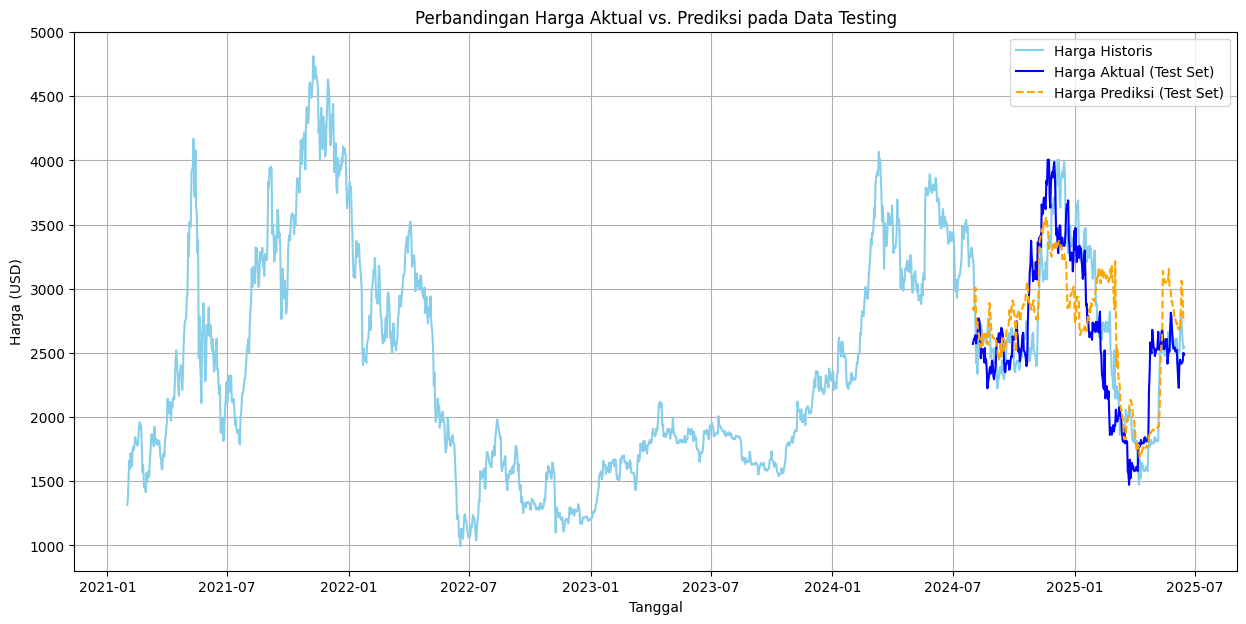

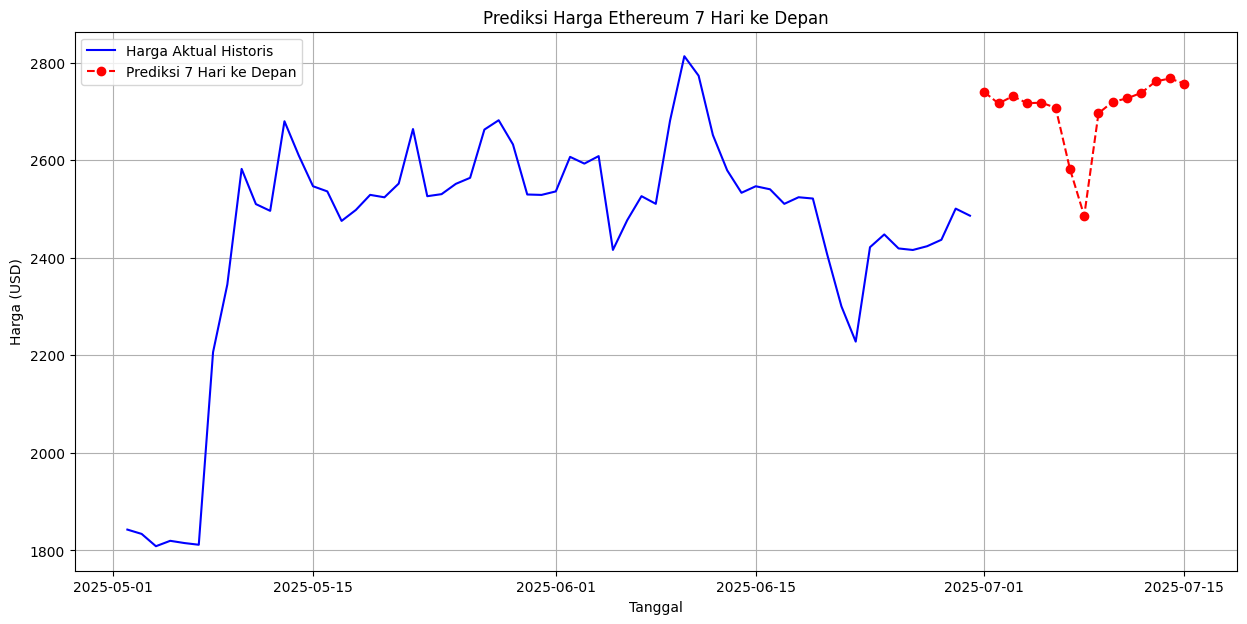

In [12]:
# ==============================================================================
# LANGKAH 9: VISUALISASI HASIL
# ==============================================================================
# Membuat DataFrame untuk visualisasi hasil di data test
results_df = pd.DataFrame({'Harga Aktual': y_test, 'Harga Prediksi': y_pred})
results_df.index = y_test.index

# Plot hasil pada data testing
plt.figure(figsize=(15, 7))
plt.plot(data_cleaned.index, data_cleaned['Close'], label='Harga Historis', color='skyblue')
plt.plot(results_df.index, results_df['Harga Aktual'], label='Harga Aktual (Test Set)', color='blue')
plt.plot(results_df.index, results_df['Harga Prediksi'], label='Harga Prediksi (Test Set)', color='orange', linestyle='--')
plt.title('Perbandingan Harga Aktual vs. Prediksi pada Data Testing')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot prediksi 7 hari ke depan
plt.figure(figsize=(15, 7))
# Tampilkan data 60 hari terakhir untuk konteks
plt.plot(data['Close'].iloc[-60:], label='Harga Aktual Historis', color='blue')
# Tampilkan hasil prediksi masa depan
plt.plot(df_predictions.index, df_predictions['Prediksi Harga (USD)'], label='Prediksi 7 Hari ke Depan', color='red', marker='o', linestyle='--')
plt.title('Prediksi Harga Ethereum 7 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import os

# Simpan model
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model using save_model
model.save_model('models/xgbost_model.json') # XGBoost recommends saving in JSON format

print("\nModel XGBoost berhasil dilatih dan disimpan di 'models'")


Model XGBoost berhasil dilatih dan disimpan di 'models'
